In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'mfcc_max_len': 100,
    'mfcc_n_coef': 40,
    'bert_max_len': 32,
    'bert_hidden_dim': 768,
    'rnn_hidden_dim': 128,
    'batch_size': 16,
    'learning_rate': 5e-5,  # Reduced learning rate
    'epochs': 10,  # Increased epochs
    'dropout': 0.7,  # Increased dropout
    'weight_decay': 1e-3,  # Increased weight decay
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"Device: {CONFIG['device']}")
print("Configuration loaded successfully!")

c:\Users\Shane\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Configuration loaded successfully!


In [2]:
def load_csvs_from_dir(directory):
    """Load all CSV files from a directory and combine them"""
    dfs = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def load_and_process_text_data():
    """Load and process text dataset"""
    label_mapping_text = {
        0: 'depressed', 1: 'optimistic', 3: 'bitter', 
        4: 'scared', 5: 'startled'
    }

    # Load all splits efficiently
    text_dfs = []
    for split in ['train', 'validation', 'test']:
        split_df = load_csvs_from_dir(f"dataset/text/{split}")
        if not split_df.empty:
            text_dfs.append(split_df)
    
    if not text_dfs:
        raise ValueError("No text data found")
    
    text_df = pd.concat(text_dfs, ignore_index=True)
    
    # Filter and map labels
    text_df = text_df[text_df['label'].isin(label_mapping_text.keys())].copy()
    text_df['label'] = text_df['label'].map(label_mapping_text)
    text_df = text_df.reset_index(drop=True)
    
    # Save processed data
    os.makedirs("dataset", exist_ok=True)
    text_df.to_csv("dataset/processed_text_dataset.csv", index=False)
    
    return text_df

def load_and_process_speech_data():
    """Load and process speech dataset"""
    label_mapping_speech = {
        'happy': 'optimistic', 'sad': 'depressed', 'angry': 'bitter',
        'fear': 'scared', 'ps': 'startled'
    }
    
    speech_dir = 'dataset/speech'
    speech_data = []
    
    for file in os.listdir(speech_dir):
        if file.endswith('.wav'):
            parts = file.split('_')
            if len(parts) == 3:
                word = parts[1]
                emotion = parts[2].replace('.wav', '')
                if emotion in label_mapping_speech:
                    speech_data.append({
                        'word': word,
                        'label': label_mapping_speech[emotion],
                        'speech_path': os.path.join(speech_dir, file)
                    })
    
    speech_df = pd.DataFrame(speech_data)
    speech_df.to_csv("dataset/processed_speech_dataset.csv", index=False)
    
    return speech_df

print("Data loading functions defined!")
# Load and process text data
print("Loading text dataset...")
text_df = load_and_process_text_data()
print(f"Text dataset shape: {text_df.shape}")
print("Text label distribution:")
print(text_df['label'].value_counts())

# Load and process speech data  
print("\nLoading speech dataset...")
speech_df = load_and_process_speech_data()
print(f"Speech dataset shape: {speech_df.shape}")
print("Speech label distribution:")
print(speech_df['label'].value_counts())


Data loading functions defined!
Loading text dataset...
Text dataset shape: (18359, 2)
Text label distribution:
label
optimistic    6761
depressed     5797
bitter        2709
scared        2373
startled       719
Name: count, dtype: int64

Loading speech dataset...
Speech dataset shape: (1000, 3)
Speech label distribution:
label
bitter        200
scared        200
optimistic    200
startled      200
depressed     200
Name: count, dtype: int64


In [3]:
def create_balanced_pairs(speech_df, text_df):
    """Create balanced speech-text pairs using upsampling strategy"""
    # First, ensure we only work with emotions/labels that exist in both datasets
    common_labels = set(speech_df['label'].unique()) & set(text_df['label'].unique())
    
    # Filter dataframes to only include common labels
    speech_df = speech_df[speech_df['label'].isin(common_labels)]
    text_df = text_df[text_df['label'].isin(common_labels)]
    
    # Get label counts
    speech_counts = speech_df['label'].value_counts()
    text_counts = text_df['label'].value_counts()
    
    print(f"Original speech counts: {speech_counts.to_dict()}")
    print(f"Original text counts: {text_counts.to_dict()}")
    
    # Find maximum count across both datasets
    max_count = max(speech_counts.max(), text_counts.max())
    print(f"Target samples per class: {max_count}")
    
    # Upsample both datasets to max_count
    balanced_speech_list = []
    balanced_text_list = []
    
    for label in common_labels:
        # Upsample speech data
        speech_subset = speech_df[speech_df['label'] == label]
        if len(speech_subset) < max_count:
            speech_upsampled = resample(speech_subset, 
                                      n_samples=max_count, 
                                      random_state=42,
                                      replace=True)
        else:
            speech_upsampled = speech_subset.sample(n=max_count, random_state=42)
        balanced_speech_list.append(speech_upsampled)
        
        # Upsample text data
        text_subset = text_df[text_df['label'] == label]
        if len(text_subset) < max_count:
            text_upsampled = resample(text_subset, 
                                    n_samples=max_count, 
                                    random_state=42,
                                    replace=True)
        else:
            text_upsampled = text_subset.sample(n=max_count, random_state=42)
        balanced_text_list.append(text_upsampled)
    
    balanced_speech_df = pd.concat(balanced_speech_list, ignore_index=True)
    balanced_text_df = pd.concat(balanced_text_list, ignore_index=True)

    # Shuffle to mix different labels
    balanced_speech_df = balanced_speech_df.sample(frac=1, random_state=42).reset_index(drop=True)
    balanced_text_df = balanced_text_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Final balanced dataset size: {len(balanced_speech_df)} pairs")
    
    return balanced_speech_df, balanced_text_df

# Create label encoder
print("Creating label encoder...")
label_encoder = LabelEncoder()

# Convert all labels to strings before encoding
all_labels = pd.concat([
    speech_df['label'].astype(str), 
    text_df['label'].astype(str)
], ignore_index=True)
label_encoder.fit(all_labels)

# Transform labels
speech_df['label'] = label_encoder.transform(speech_df['label'].astype(str))
text_df['label'] = label_encoder.transform(text_df['label'].astype(str))
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

# Create balanced pairs
print("\nCreating balanced dataset...")
# First split original (unbalanced) data
speech_train, speech_val = train_test_split(speech_df, test_size=0.2, random_state=42, stratify=speech_df['label'])
text_train,   text_val   = train_test_split(text_df,   test_size=0.2, random_state=42, stratify=text_df['label'])

# Then balance each split separately
balanced_speech_train, balanced_text_train = create_balanced_pairs(speech_train, text_train)
balanced_speech_val,   balanced_text_val   = create_balanced_pairs(speech_val, text_val)

print("Final balanced distribution:")
print("Speech train:", balanced_speech_train['label'].value_counts().to_dict())
print("Text train:", balanced_text_train['label'].value_counts().to_dict())

print("Speech val:", balanced_speech_val['label'].value_counts().to_dict())
print("Text val:", balanced_text_val['label'].value_counts().to_dict())
print(balanced_speech_train)

Creating label encoder...
Number of classes: 5
Classes: ['bitter' 'depressed' 'optimistic' 'scared' 'startled']

Creating balanced dataset...
Original speech counts: {1: 160, 3: 160, 4: 160, 2: 160, 0: 160}
Original text counts: {2: 5409, 1: 4638, 0: 2167, 3: 1898, 4: 575}
Target samples per class: 5409
Final balanced dataset size: 27045 pairs
Original speech counts: {2: 40, 0: 40, 1: 40, 3: 40, 4: 40}
Original text counts: {2: 1352, 1: 1159, 0: 542, 3: 475, 4: 144}
Target samples per class: 1352
Final balanced dataset size: 6760 pairs
Final balanced distribution:
Speech train: {1: 5409, 4: 5409, 3: 5409, 0: 5409, 2: 5409}
Text train: {1: 5409, 4: 5409, 3: 5409, 0: 5409, 2: 5409}
Speech val: {4: 1352, 3: 1352, 2: 1352, 1: 1352, 0: 1352}
Text val: {4: 1352, 3: 1352, 2: 1352, 1: 1352, 0: 1352}
        word  label                         speech_path
0        wag      1      dataset/speech\YAF_wag_sad.wav
1        rag      4       dataset/speech\YAF_rag_ps.wav
2        gin      3     datas

In [4]:
class FeatureExtractor:
    def __init__(self):
        print("Loading BERT model and tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.bert_model = AutoModel.from_pretrained("bert-base-uncased")
        self.bert_model.eval()  # Set to eval mode
        
        # Move to device
        self.bert_model = self.bert_model.to(CONFIG['device'])
        
        # Cache for features
        self.mfcc_cache = {}
        self.bert_cache = {}
        print("Feature extractor initialized!")
    
    def extract_mfcc(self, wav_path, max_len=None):
        """Extract MFCC features with caching"""
        if max_len is None:
            max_len = CONFIG['mfcc_max_len']
            
        if wav_path in self.mfcc_cache:
            return self.mfcc_cache[wav_path]
        
        try:
            y, sr = librosa.load(wav_path, sr=16000)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG['mfcc_n_coef'])
            
            if mfcc.shape[1] < max_len:
                pad_width = max_len - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0,0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :max_len]
            
            mfcc_transposed = mfcc.T
            self.mfcc_cache[wav_path] = mfcc_transposed
            return mfcc_transposed
        except Exception as e:
            print(f"Error loading {wav_path}: {e}")
            # Return zero-filled array as fallback
            return np.zeros((max_len, CONFIG['mfcc_n_coef']))
    
    def extract_bert_embedding(self, text):
        """Extract BERT embeddings with caching"""
        if text in self.bert_cache:
            return self.bert_cache[text]
        
        inputs = self.tokenizer(text, 
                              return_tensors="pt", 
                              padding=True, 
                              truncation=True, 
                              max_length=CONFIG['bert_max_len'])
        
        # Move to device
        inputs = {k: v.to(CONFIG['device']) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        self.bert_cache[text] = embedding
        return embedding

# Initialize feature extractor
feature_extractor = FeatureExtractor()

# Test feature extraction
print("Testing feature extraction...")

# Test MFCC extraction (train)
sample_speech_train = balanced_speech_train.iloc[0]
mfcc_features = feature_extractor.extract_mfcc(sample_speech_train['speech_path'])
print(f"MFCC shape: {mfcc_features.shape}")

# Test BERT extraction (val)
sample_speech_val = balanced_speech_val.iloc[0]
mfcc_features_val = feature_extractor.extract_mfcc(sample_speech_val['speech_path'])
print(f"MFCC shape (val): {mfcc_features_val.shape}")

# Test BERT extraction (train)
sample_text_train = balanced_text_train.iloc[0]
bert_features = feature_extractor.extract_bert_embedding(sample_text_train['text'])
print(f"BERT shape: {bert_features.shape}")

# Test BERT extraction (val)
sample_text_val = balanced_text_val.iloc[0]
bert_features_val = feature_extractor.extract_bert_embedding(sample_text_val['text'])
print(f"BERT shape (val): {bert_features_val.shape}")

# Test fusion
bert_repeated = np.repeat(bert_features[np.newaxis, :], mfcc_features.shape[0], axis=0)
fused_features = np.concatenate((mfcc_features, bert_repeated), axis=1)
print(f"Fused features shape: {fused_features.shape}")
print("MFCC:", mfcc_features_val)
print("BERT:", bert_features_val)
print("Fused:", fused_features)
print("Feature extraction test successful!")

Loading BERT model and tokenizer...
Feature extractor initialized!
Testing feature extraction...
MFCC shape: (100, 40)
MFCC shape (val): (100, 40)
BERT shape: (768,)
BERT shape (val): (768,)
Fused features shape: (100, 808)
MFCC: [[-553.9661      -37.979538     62.596302   ...    1.8573265
    -4.724202      8.321705  ]
 [-509.34814     -39.292984     76.30798    ...    3.1172159
    -4.8837075     6.414671  ]
 [-481.77203     -41.639267     65.93657    ...    4.87666
    -0.59297997    6.7665944 ]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]
BERT: [-1.68684050e-02  3.20604324e-01  3.46596420e-01 -5.71069121e-01
  1.14969008e-01 -1.64982557e-01  4.44355696e-01  7.51679659e-01
 -1.14768840e-01 -7.19419718e-01  1.72390074e-01 -5.17538190e-01
  2.89220810e-02  6.17551804e-01 -

In [5]:
class OptimizedEarlyFusionDataset(Dataset):
    def __init__(self, speech_df, text_df, feature_extractor, train_mode=True):
        self.feature_extractor = feature_extractor
        self.data_pairs = []
        self.train_mode = train_mode
        
        print("Preprocessing all features...")
        
        min_samples = min(len(speech_df), len(text_df))
        for i in range(min_samples):
            if i % 1000 == 0:
                print(f"Processed {i}/{min_samples} samples")
                
            speech_row = speech_df.iloc[i]
            text_row = text_df.iloc[i]
            
            # Extract features
            mfcc = self.feature_extractor.extract_mfcc(speech_row['speech_path'])
            bert = self.feature_extractor.extract_bert_embedding(text_row['text'])
            
            # Create fused feature
            bert_repeated = np.repeat(bert[np.newaxis, :], mfcc.shape[0], axis=0)
            fused = np.concatenate((mfcc, bert_repeated), axis=1)
            
            # Convert to tensor
            fused_tensor = torch.tensor(fused, dtype=torch.float32)
            
            self.data_pairs.append({
                'features': fused_tensor,
                'label': torch.tensor(speech_row['label'], dtype=torch.long)
            })
        
        print(f"Preprocessing complete! Dataset size: {len(self.data_pairs)}")
    
    def add_noise(self, features):
        # Add Gaussian noise during training
        if self.train_mode:
            noise = torch.randn_like(features) * 0.1
            return features + noise
        return features
    
    def __len__(self):
        return len(self.data_pairs)
    
    def __getitem__(self, idx):
        features = self.data_pairs[idx]['features']
        features = self.add_noise(features)
        return features, self.data_pairs[idx]['label']

# Create the full dataset
print("Creating optimized dataset...")
# Build datasets
train_dataset = OptimizedEarlyFusionDataset(balanced_speech_train, balanced_text_train, feature_extractor)
val_dataset   = OptimizedEarlyFusionDataset(balanced_speech_val,   balanced_text_val,   feature_extractor)

# Test the dataset
sample_features, sample_label = train_dataset[0]
print(f"Sample features shape: {sample_features.shape}")
print(f"Sample label: {sample_label}")


Creating optimized dataset...
Preprocessing all features...
Processed 0/27045 samples
Processed 1000/27045 samples
Processed 2000/27045 samples
Processed 3000/27045 samples
Processed 4000/27045 samples
Processed 5000/27045 samples
Processed 6000/27045 samples
Processed 7000/27045 samples
Processed 8000/27045 samples
Processed 9000/27045 samples
Processed 10000/27045 samples
Processed 11000/27045 samples
Processed 12000/27045 samples
Processed 13000/27045 samples
Processed 14000/27045 samples
Processed 15000/27045 samples
Processed 16000/27045 samples
Processed 17000/27045 samples
Processed 18000/27045 samples
Processed 19000/27045 samples
Processed 20000/27045 samples
Processed 21000/27045 samples
Processed 22000/27045 samples
Processed 23000/27045 samples
Processed 24000/27045 samples
Processed 25000/27045 samples
Processed 26000/27045 samples
Processed 27000/27045 samples
Preprocessing complete! Dataset size: 27045
Preprocessing all features...
Processed 0/6760 samples
Processed 1000

In [6]:
class ImprovedEarlyFusionRNN(nn.Module):
    def __init__(self, input_dim=808, hidden_dim=128, num_classes=5, dropout=0.5):
        super(ImprovedEarlyFusionRNN, self).__init__()
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(input_dim)
        
        # Dropout for input
        self.input_dropout = nn.Dropout(dropout)
        
        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim * 2,
            num_layers=2,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim * 4)  # *4 because bidirectional
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
        # Weight initialization
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)
    
    def forward(self, x):
        # Input shape: (batch, sequence_length, features)
        
        # Apply layer normalization and dropout
        x = self.layer_norm(x)
        x = self.input_dropout(x)
        
        # LSTM layers
        lstm_out, _ = self.lstm1(x)  # output: (batch, seq_len, hidden_dim*4)
        
        # Apply batch normalization
        batch_size, seq_len, hidden_size = lstm_out.size()
        lstm_out = lstm_out.transpose(1, 2)  # (batch, hidden_dim*4, seq_len)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.transpose(1, 2)  # (batch, seq_len, hidden_dim*4)
        
        # Global average pooling over sequence length
        lstm_out = lstm_out.transpose(1, 2)  # (batch, hidden_dim*4, seq_len)
        pooled = self.global_pool(lstm_out)  # (batch, hidden_dim*4, 1)
        pooled = pooled.squeeze(-1)  # (batch, hidden_dim*4)
        
        # Classification
        output = self.classifier(pooled)
        return output

# Initialize model with the same configuration
input_dim = CONFIG['mfcc_n_coef'] + CONFIG['bert_hidden_dim']
model = ImprovedEarlyFusionRNN(
    input_dim=input_dim,
    hidden_dim=CONFIG['rnn_hidden_dim'],
    num_classes=len(label_encoder.classes_),
    dropout=CONFIG['dropout']
).to(CONFIG['device'])

print(f"RNN Model created with input dim: {input_dim}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

RNN Model created with input dim: 808
Model parameters: 3,928,405


In [7]:
def collate_fn(batch):
    """Improved collate function with proper padding"""
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    padded = nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    return padded, torch.tensor(labels), torch.tensor(lengths)

def evaluate_model(model, loader, criterion, device):
    """Comprehensive model evaluation"""
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y, lengths in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == batch_y).sum().item()
            total_samples += batch_y.size(0)
    
    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(loader)
    return accuracy, avg_loss

print("Training utilities defined!")

Training utilities defined!


In [8]:
# Split into train and validation
print("Creating train/validation split...")
# train_indices, val_indices = train_test_split(
#     list(range(len(full_dataset))), 
#     test_size=0.2, 
#     random_state=42,
#     stratify=[full_dataset[i][1].item() for i in range(len(full_dataset))]
# )

# print(f"Train samples: {len(train_indices)}")
# print(f"Validation samples: {len(val_indices)}")

# train_subset = torch.utils.data.Subset(full_dataset, train_indices)
# val_subset = torch.utils.data.Subset(full_dataset, val_indices)

# Create data loaders
# Loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

print("Data loaders created successfully!")

# Test data loading
print("Testing data loaders...")
for batch_x, batch_y, lengths in train_loader:
    print(f"Batch input shape: {batch_x.shape}")
    print(f"Batch labels shape: {batch_y.shape}")
    print(f"Batch lengths shape: {lengths.shape}")
    break


# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                      mode='min', 
                                                      factor=0.5, 
                                                      patience=5)

print("Training setup complete!")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Loss function: {criterion.__class__.__name__}")


Creating train/validation split...
Data loaders created successfully!
Testing data loaders...
Batch input shape: torch.Size([16, 100, 808])
Batch labels shape: torch.Size([16])
Batch lengths shape: torch.Size([16])
Training setup complete!
Optimizer: AdamW
Learning rate: 5e-05
Loss function: CrossEntropyLoss


In [9]:
# Training variables
best_val_acc = 0
training_history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("Starting training...")
print("="*60)

for epoch in range(CONFIG['epochs']):
    # Training
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch_x, batch_y, lengths in train_loader:
        batch_x, batch_y = batch_x.to(CONFIG['device']), batch_y.to(CONFIG['device'])
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == batch_y).sum().item()
        total_samples += batch_y.size(0)
    
    train_acc = total_correct / total_samples
    train_loss = total_loss / len(train_loader)
    
    # Validation
    val_acc, val_loss = evaluate_model(model, val_loader, criterion, CONFIG['device'])
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'rnn_early_fusion_model.pth')
    
    # Store history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:5.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:5.2f}%, "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")

print("="*60)
print(f"Training complete! Best validation accuracy: {best_val_acc*100:.2f}%")




Starting training...
Epoch  1/10, Train Loss: 1.0636, Train Acc: 71.67%, Val Loss: 0.5003, Val Acc: 99.82%, LR: 5.00e-05
Epoch  2/10, Train Loss: 0.5418, Train Acc: 97.48%, Val Loss: 0.4530, Val Acc: 100.00%, LR: 5.00e-05
Epoch  3/10, Train Loss: 0.4894, Train Acc: 99.38%, Val Loss: 0.4266, Val Acc: 100.00%, LR: 5.00e-05
Epoch  4/10, Train Loss: 0.4705, Train Acc: 99.71%, Val Loss: 0.4151, Val Acc: 100.00%, LR: 5.00e-05
Epoch  5/10, Train Loss: 0.4599, Train Acc: 99.89%, Val Loss: 0.4989, Val Acc: 97.37%, LR: 5.00e-05
Epoch  6/10, Train Loss: 0.4532, Train Acc: 99.93%, Val Loss: 0.4059, Val Acc: 100.00%, LR: 5.00e-05
Epoch  7/10, Train Loss: 0.4493, Train Acc: 99.96%, Val Loss: 0.4089, Val Acc: 99.76%, LR: 5.00e-05
Epoch  8/10, Train Loss: 0.4436, Train Acc: 99.97%, Val Loss: 0.4011, Val Acc: 100.00%, LR: 5.00e-05
Epoch  9/10, Train Loss: 0.4412, Train Acc: 99.99%, Val Loss: 0.4001, Val Acc: 100.00%, LR: 5.00e-05
Epoch 10/10, Train Loss: 0.4390, Train Acc: 99.98%, Val Loss: 0.4018, Val

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
Balanced Accuracy: 1.0
ROC-AUC: 1.0


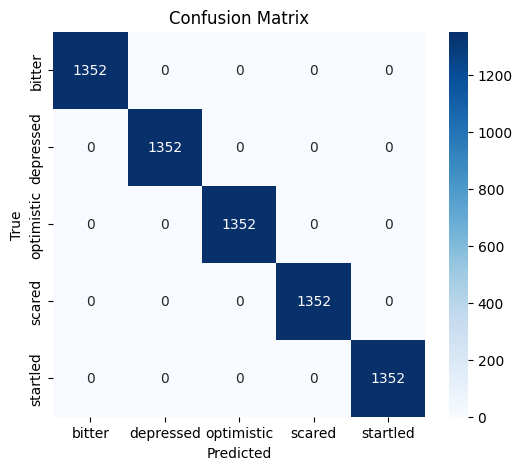

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, balanced_accuracy_score, confusion_matrix, RocCurveDisplay
)
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Collect predictions ===
model.eval()
y_true, y_pred, y_proba = [], [], []

with torch.no_grad():
    for X_batch, y_batch, lengths in val_loader:
        X_batch, y_batch = X_batch.to(CONFIG['device']), y_batch.to(CONFIG['device'])
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_proba.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

# === Metrics ===
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("F1-Score:", f1_score(y_true, y_pred, average="weighted"))
print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred))

# ROC-AUC (multi-class: one-vs-rest)
try:
    roc_auc = roc_auc_score(y_true, y_proba, multi_class="ovr", average="weighted")
    print("ROC-AUC:", roc_auc)
except Exception as e:
    print("ROC-AUC could not be computed:", e)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
 
# # === ROC Curve ===
# if y_proba.shape[1] == 2:  # binary case
#     RocCurveDisplay.from_predictions(y_true, y_proba[:,1])
#     plt.title("ROC Curve")
#     plt.show()


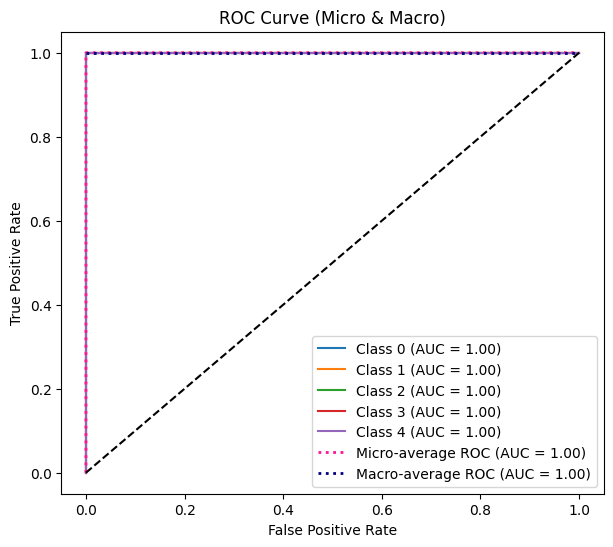

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize
classes = np.unique(y_true)
y_true_bin = label_binarize(y_true, classes=classes)

# Micro-average ROC
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
roc_auc_micro = auc(fpr, tpr)

# Macro-average ROC
fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
for i in range(len(classes)):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
mean_tpr /= len(classes)
roc_auc_macro = auc(all_fpr, mean_tpr)

# === Plot ===
plt.figure(figsize=(7,6))

# Per-class ROC
for i in range(len(classes)):
    plt.plot(fpr_dict[i], tpr_dict[i],
             label=f"Class {classes[i]} (AUC = {roc_auc_dict[i]:.2f})")

# Micro and Macro
plt.plot(fpr, tpr, color='deeppink', linestyle=':', linewidth=2,
         label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})")
plt.plot(all_fpr, mean_tpr, color='navy', linestyle=':', linewidth=2,
         label=f"Macro-average ROC (AUC = {roc_auc_macro:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro & Macro)")
plt.legend(loc="lower right")
plt.show()

Train shape: (27045, 100, 808) (27045,)
Val shape: (6760, 100, 808) (6760,)
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.5932       0.9993        0.0107  17.3516
      2        0.0937       1.0000        0.0020  15.0359
      3        0.0491       1.0000        0.0010  15.3092
      4        0.0333       1.0000        0.0010  14.4761
      5        0.0231       1.0000        0.0003  14.3846
      6        0.0228       1.0000        0.0002  14.4692
      7        0.0155       1.0000        0.0002  14.2955
      8        0.0158       1.0000        0.0001  14.2816
      9        0.0113       1.0000        0.0001  14.1563
     10        0.0106       1.0000        0.0001  14.1500
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6213       1.0000        0.0121  24.9284
      2        0.1022       1.0000        0.0036  29.6

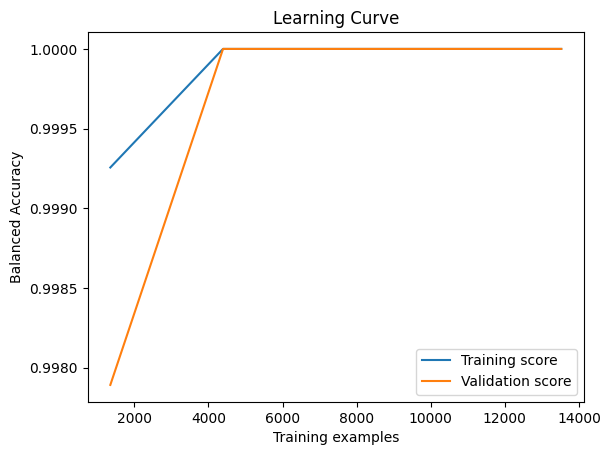

In [12]:
from skorch import NeuralNetClassifier
import torch.nn as nn

# Example: assuming your model class is ImprovedEarlyFusionRNN
net = NeuralNetClassifier(
    ImprovedEarlyFusionRNN,
    module__num_classes=len(label_encoder.classes_),  # pass num_classes if needed
    max_epochs=CONFIG['epochs'],
    lr=CONFIG['learning_rate'],
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device=CONFIG['device'],  # "cuda" or "cpu"
    batch_size=CONFIG['batch_size'],
)


# Convert dataset to numpy arrays
def dataset_to_numpy(dataset):
    X, y = [], []
    for features, label in dataset:
        X.append(features.numpy())
        y.append(label.item())
    return np.array(X), np.array(y)

X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val     = dataset_to_numpy(val_dataset)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)


from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Balanced Accuracy
cv_bal_acc = cross_val_score(net, X_train, y_train, cv=cv, scoring="balanced_accuracy")
print("Cross-Validated Balanced Accuracy:", cv_bal_acc.mean())

# ROC-AUC (multi-class one-vs-rest)
cv_roc_auc = cross_val_score(net, X_train, y_train, cv=cv, scoring="roc_auc_ovr_weighted")
print("Cross-Validated ROC-AUC:", cv_roc_auc.mean())


from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    net, X_train, y_train,
    cv=cv,
    scoring="balanced_accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, val_mean, label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Balanced Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()


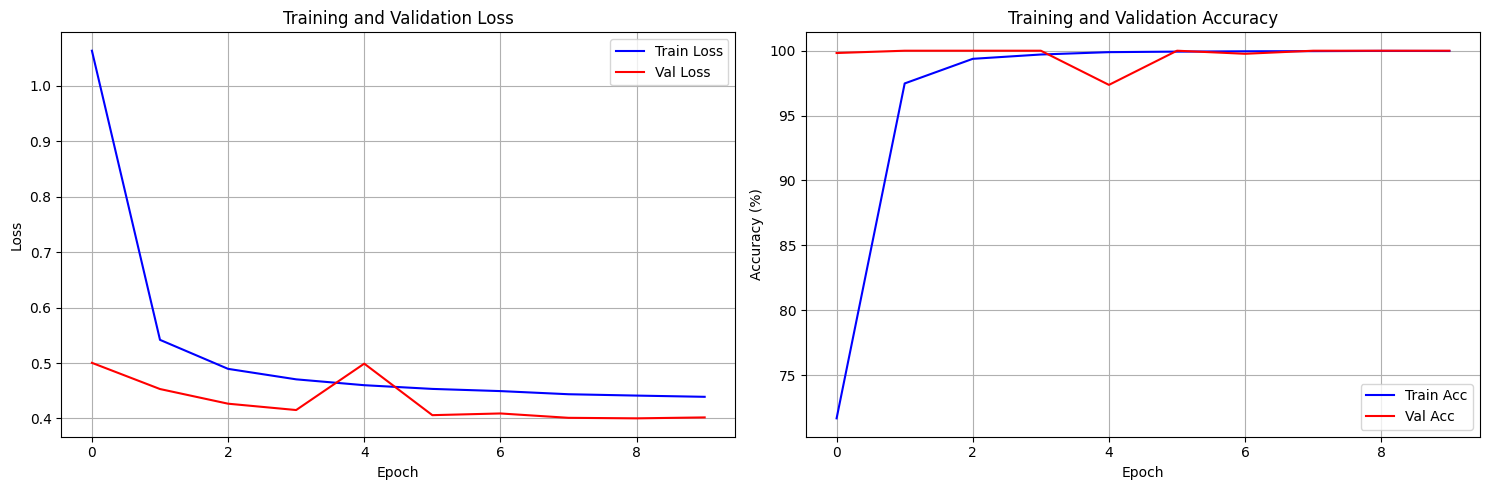


FINAL RESULTS
Best Validation Accuracy: 100.00%
Final Train Accuracy: 99.98%
Final Validation Accuracy: 100.00%
Total Parameters: 3,928,405
Dataset Size: Train: 27,045, Validation: 6,760 samples
Classes: ['bitter' 'depressed' 'optimistic' 'scared' 'startled']
Training history saved to 'training_history.csv'


In [13]:
import matplotlib.pyplot as plt

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(training_history['train_loss'], label='Train Loss', color='blue')
ax1.plot(training_history['val_loss'], label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot([acc*100 for acc in training_history['train_acc']], label='Train Acc', color='blue')
ax2.plot([acc*100 for acc in training_history['val_acc']], label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Final Train Accuracy: {training_history['train_acc'][-1]*100:.2f}%")
print(f"Final Validation Accuracy: {training_history['val_acc'][-1]*100:.2f}%")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Dataset Size: Train: {len(train_dataset):,}, Validation: {len(val_dataset):,} samples")
print(f"Classes: {label_encoder.classes_}")

# Save training history
history_df = pd.DataFrame(training_history)
history_df.to_csv('training_history.csv', index=False)
print("Training history saved to 'training_history.csv'")

In [14]:
def export_results_and_features(feature_extractor, prefix="sample", out_dir="output"):
    """
    Export evaluation metrics, results, and extracted features to one Excel file + CSV backups
    """
    import os
    os.makedirs(out_dir, exist_ok=True)

    # =====================
    # 1. Evaluation Metrics
    # =====================
    class_metrics = {
        'class': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'support': []
    }
    
    for i, class_name in enumerate(label_encoder.classes_):
        precision = precision_score(y_true, y_pred, labels=[i], average=None)[0]
        recall = recall_score(y_true, y_pred, labels=[i], average=None)[0]
        f1 = f1_score(y_true, y_pred, labels=[i], average=None)[0]
        support = np.sum(y_true == i)
        
        class_metrics['class'].append(class_name)
        class_metrics['precision'].append(precision)
        class_metrics['recall'].append(recall)
        class_metrics['f1_score'].append(f1)
        class_metrics['support'].append(support)
    
    class_df = pd.DataFrame(class_metrics)
    
    overall_metrics = {
        'metric': [
            'accuracy',
            'weighted_precision',
            'weighted_recall',
            'weighted_f1',
            'balanced_accuracy',
            'roc_auc_weighted'
        ],
        'value': [
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, average='weighted'),
            recall_score(y_true, y_pred, average='weighted'),
            f1_score(y_true, y_pred, average='weighted'),
            balanced_accuracy_score(y_true, y_pred),
            roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
        ]
    }
    overall_df = pd.DataFrame(overall_metrics)
    
    history_df = pd.DataFrame(training_history)
    config_df = pd.DataFrame([CONFIG])
    
    dataset_info = {
        'dataset': ['train', 'validation'],
        'size': [len(train_dataset), len(val_dataset)]
    }
    dataset_df = pd.DataFrame(dataset_info)
    
    cm_df = pd.DataFrame(
        confusion_matrix(y_true, y_pred),
        columns=label_encoder.classes_,
        index=label_encoder.classes_
    )
    
    # =====================
    # 2. Feature Extraction
    # =====================
    sample_speech_train = balanced_speech_train.iloc[0]
    sample_speech_val = balanced_speech_val.iloc[0]
    sample_text_train = balanced_text_train.iloc[0]
    sample_text_val = balanced_text_val.iloc[0]

    # Train
    mfcc_train = feature_extractor.extract_mfcc(sample_speech_train['speech_path'])
    bert_train = feature_extractor.extract_bert_embedding(sample_text_train['text'])
    bert_repeated = np.repeat(bert_train[np.newaxis, :], mfcc_train.shape[0], axis=0)
    fused_train = np.concatenate((mfcc_train, bert_repeated), axis=1)

    # Val
    mfcc_val = feature_extractor.extract_mfcc(sample_speech_val['speech_path'])
    bert_val = feature_extractor.extract_bert_embedding(sample_text_val['text'])
    bert_repeated_val = np.repeat(bert_val[np.newaxis, :], mfcc_val.shape[0], axis=0)
    fused_val = np.concatenate((mfcc_val, bert_repeated_val), axis=1)

    # Convert to DataFrames
    mfcc_train_df = pd.DataFrame(mfcc_train)
    bert_train_df = pd.DataFrame([bert_train])
    fused_train_df = pd.DataFrame(fused_train)

    mfcc_val_df = pd.DataFrame(mfcc_val)
    bert_val_df = pd.DataFrame([bert_val])
    fused_val_df = pd.DataFrame(fused_val)

    # =====================
    # 3. Save to ONE Excel
    # =====================
    excel_path = os.path.join(out_dir, 'evaluation_results.xlsx')
    with pd.ExcelWriter(excel_path) as writer:
        overall_df.to_excel(writer, sheet_name='Overall Metrics', index=False)
        class_df.to_excel(writer, sheet_name='Class Metrics', index=False)
        history_df.to_excel(writer, sheet_name='Training History', index=False)
        config_df.to_excel(writer, sheet_name='Model Config', index=False)
        dataset_df.to_excel(writer, sheet_name='Dataset Info', index=False)
        cm_df.to_excel(writer, sheet_name='Confusion Matrix')
        
        # Add features
        mfcc_train_df.to_excel(writer, sheet_name=f'{prefix}_Train_MFCC', index=False)
        bert_train_df.to_excel(writer, sheet_name=f'{prefix}_Train_BERT', index=False)
        fused_train_df.to_excel(writer, sheet_name=f'{prefix}_Train_Fused', index=False)
        mfcc_val_df.to_excel(writer, sheet_name=f'{prefix}_Val_MFCC', index=False)
        bert_val_df.to_excel(writer, sheet_name=f'{prefix}_Val_BERT', index=False)
        fused_val_df.to_excel(writer, sheet_name=f'{prefix}_Val_Fused', index=False)

    print(f"✅ All results and features saved in ONE Excel: {excel_path}")

    return {
        'overall': overall_df,
        'class': class_df,
        'history': history_df,
        'config': config_df,
        'dataset': dataset_df,
        'confusion_matrix': cm_df,
        'features': {
            'train': {'mfcc': mfcc_train, 'bert': bert_train, 'fused': fused_train},
            'val': {'mfcc': mfcc_val, 'bert': bert_val, 'fused': fused_val}
        }
    }
    
results = export_results_and_features(
    feature_extractor=feature_extractor,
    prefix="multimodal",  # Optional: customize prefix for feature sheets
    out_dir="rnn"      # Optional: customize output directory
)




✅ All results and features saved in ONE Excel: rnn\evaluation_results.xlsx
